In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

df = None

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        df = pd.read_csv(os.path.join(dirname, filename)).reset_index(drop=True)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
df.shape

(7267, 39)

In [4]:
df.head()

,Unnamed: 0,text,*special problem,2-sat,binary search,bitmasks,brute force,chinese remainder theorem,combinatorics,constructive algorithms,...,number theory,probabilities,schedules,shortest paths,sortings,string suffix structures,strings,ternary search,trees,two pointers
0,0,E. Middle Duplication\ntime limit per test\n1 ...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1,D. Robot Cleaner Revisit\ntime limit per test\...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,C. Balanced Stone Heaps\ntime limit per test\n...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,B. Game on Ranges\ntime limit per test\n1 seco...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,4,A. Robot Cleaner\ntime limit per test\n1 secon...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
target_list  = ['*special problem', '2-sat', 'binary search', 'bitmasks',
               'brute force', 'chinese remainder theorem', 'combinatorics',
               'constructive algorithms', 'data structures', 'dfs and similar',
               'divide and conquer', 'dp', 'dsu', 'expression parsing', 'fft', 'flows',
               'games', 'geometry', 'graph matchings', 'graphs', 'greedy', 'hashing',
               'implementation', 'interactive', 'math', 'matrices',
               'meet-in-the-middle', 'number theory', 'probabilities', 'schedules',
               'shortest paths', 'sortings', 'string suffix structures', 'strings',
               'ternary search', 'trees', 'two pointers']

In [6]:
df = df.drop(df.columns[0], axis = 1)

In [7]:
df.shape

(7267, 38)

In [8]:
for tag in target_list:
    df[tag] = df[tag].astype(int)

In [9]:
df.head()

,text,*special problem,2-sat,binary search,bitmasks,brute force,chinese remainder theorem,combinatorics,constructive algorithms,data structures,...,number theory,probabilities,schedules,shortest paths,sortings,string suffix structures,strings,ternary search,trees,two pointers
0,E. Middle Duplication\ntime limit per test\n1 ...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,D. Robot Cleaner Revisit\ntime limit per test\...,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,C. Balanced Stone Heaps\ntime limit per test\n...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,B. Game on Ranges\ntime limit per test\n1 seco...,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,A. Robot Cleaner\ntime limit per test\n1 secon...,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

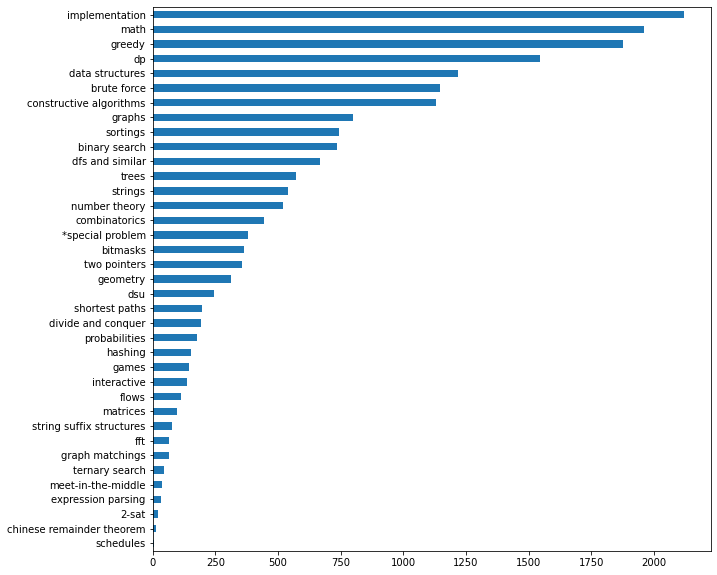

In [10]:
df[target_list].sum().sort_values().plot(kind="barh", figsize=(10,10))

In [11]:
for dropped_tag in target_list:
    if df[dropped_tag].sum() <= 200:
        df = df.drop(dropped_tag, axis=1)

In [12]:
df = df.drop("*special problem", axis=1)

In [13]:
target_list = list(df.columns[1:])

In [14]:
df.head()

,text,binary search,bitmasks,brute force,combinatorics,constructive algorithms,data structures,dfs and similar,dp,dsu,geometry,graphs,greedy,implementation,math,number theory,sortings,strings,trees,two pointers
0,E. Middle Duplication\ntime limit per test\n1 ...,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0
1,D. Robot Cleaner Revisit\ntime limit per test\...,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
2,C. Balanced Stone Heaps\ntime limit per test\n...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,B. Game on Ranges\ntime limit per test\n1 seco...,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
4,A. Robot Cleaner\ntime limit per test\n1 secon...,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0


<AxesSubplot:>

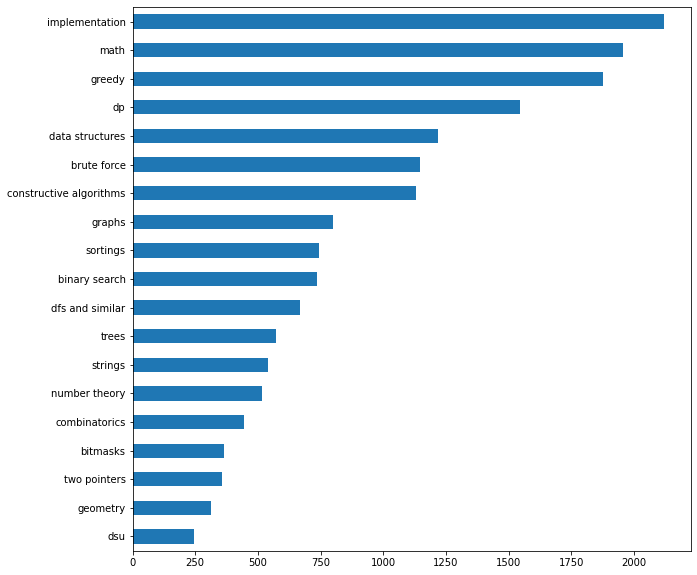

In [15]:
df[target_list].sum().sort_values().plot(kind="barh", figsize=(10,10))

In [22]:
na = []
for _ in df.iterrows():
    if sum(_[1][target_list]) == 0:
        na.append(_[0])

In [26]:
df = df.drop(na).reset_index(drop=True)

In [28]:
df.head()

,text,binary search,bitmasks,brute force,combinatorics,constructive algorithms,data structures,dfs and similar,dp,dsu,geometry,graphs,greedy,implementation,math,number theory,sortings,strings,trees,two pointers
0,E. Middle Duplication\ntime limit per test\n1 ...,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0
1,D. Robot Cleaner Revisit\ntime limit per test\...,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
2,C. Balanced Stone Heaps\ntime limit per test\n...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,B. Game on Ranges\ntime limit per test\n1 seco...,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
4,A. Robot Cleaner\ntime limit per test\n1 secon...,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0


In [29]:
df.shape

(7057, 20)

In [30]:
!pip install transformers

In [31]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import shutil

In [32]:
from transformers import BertTokenizer, BertModel

In [33]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [34]:
# hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-04
n_classes = len(target_list)

In [35]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.title = df['text']
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index])
        }

In [36]:
train_path = "train.csv"
test_path = "test.csv"

In [37]:
df[:6300].to_csv("train.csv", index = False)
df[6300:].to_csv("test.csv", index = False)

In [38]:
df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [39]:
df.shape

(6300, 20)

In [40]:
train_size = 0.8
train_df = df.sample(frac=train_size, random_state=42).reset_index(drop=True)
val_df = df.drop(train_df.index).reset_index(drop=True)

In [41]:
train_df.shape, val_df.shape

((5040, 20), (1260, 20))

<AxesSubplot:>

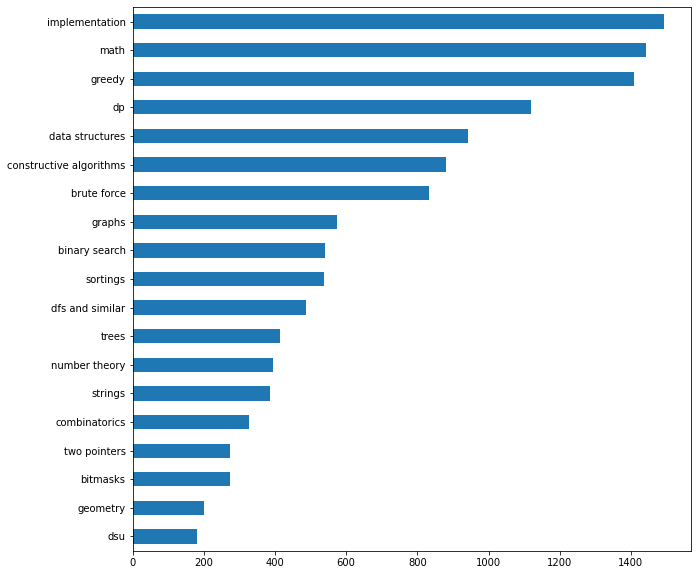

In [42]:
train_df[target_list].sum().sort_values().plot(kind="barh", figsize=(10,10))

<AxesSubplot:>

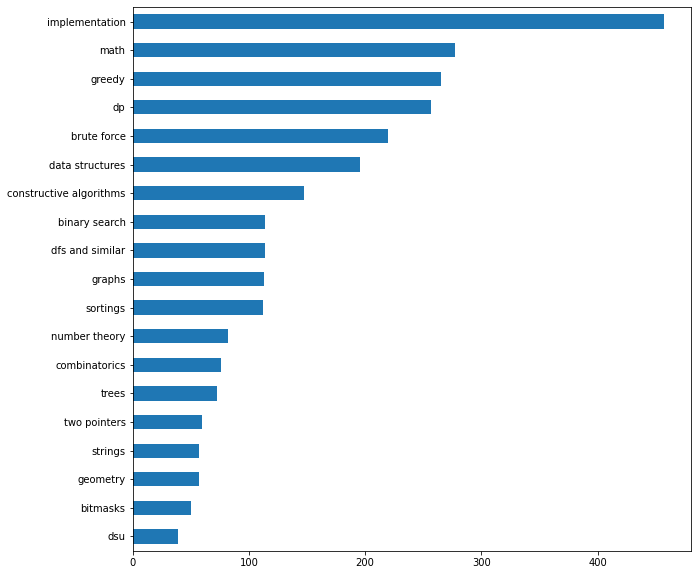

In [43]:
val_df[target_list].sum().sort_values().plot(kind="barh", figsize=(10,10))

In [44]:
train_dataset = CustomDataset(train_df, tokenizer, MAX_LEN)
valid_dataset = CustomDataset(val_df, tokenizer, MAX_LEN)

In [45]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [46]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [47]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch']

def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

In [48]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, n_classes)
    
    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()
model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [49]:
def calculate_pos_weights(class_counts):
    pos_weights = np.ones_like(class_counts)
    neg_counts = [len(train_df) - pos_count for pos_count in class_counts]
    for cdx,(pos_count, neg_count) in enumerate(zip(class_counts,  neg_counts)):
        pos_weights[cdx] = len(train_df) / pos_count
        
    return torch.as_tensor(pos_weights, dtype=torch.float)

In [50]:
class_counts = train_df[target_list].sum()
class_weights = calculate_pos_weights(class_counts).to(device)
class_weights

tensor([ 9., 18.,  6., 15.,  5.,  5., 10.,  4., 27., 25.,  8.,  3.,  3.,  3.,
        12.,  9., 13., 12., 18.], device='cuda:0')

In [51]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss(pos_weight=class_weights)(outputs, targets)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [52]:
val_targets = []
val_outputs = []

In [53]:
from sklearn.metrics import f1_score

In [55]:
train_loss_plot, valid_loss_plot, valid_acc_plot = [], [], []
def train_model(n_epochs, training_loader, validation_loader, model, 
                optimizer, checkpoint_path, best_model_path):
   
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf

    for epoch in range(1, n_epochs + 1):
        train_loss = 0
        valid_loss = 0

        model.train()
        print(f'############# Epoch {epoch}: Training Start   #############')
        for batch_idx, data in enumerate(training_loader):
            # print('yyy epoch', batch_idx)
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)

            outputs = model(ids, mask, token_type_ids)

            optimizer.zero_grad()
            loss = loss_fn(outputs, targets)
            # if batch_idx%5000==0:
            #     print(f'Epoch: {epoch}, Training Loss:  {loss.item()}')

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #print('before loss data in training', loss.item(), train_loss)
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
            #print('after loss data in training', loss.item(), train_loss)
    
        print(f"############# Epoch {epoch}: Training End     #############")
        
        print(f"############# Epoch {epoch}: Validation Start   #############")
        ######################    
        # validate the model #
        ######################
    
        model.eval()
        
        val_targets = []
        val_outputs = []

        with torch.no_grad():
            for batch_idx, data in enumerate(validation_loader, 0):
                ids = data['input_ids'].to(device, dtype = torch.long)
                mask = data['attention_mask'].to(device, dtype = torch.long)
                token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
                targets = data['targets'].to(device, dtype = torch.float)
                outputs = model(ids, mask, token_type_ids)
                
                loss = loss_fn(outputs, targets)
                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
                val_targets.extend(targets.cpu().detach().numpy().tolist())
                val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

            print(f'############# Epoch {epoch}: Validation End     #############')
        # calculate average losses
        #print('before cal avg train loss', train_loss)
            train_loss = train_loss/len(training_loader)
            valid_loss = valid_loss/len(validation_loader)
        # print training/validation statistics 
            
            val_outputs  = np.array(val_outputs)
            val_targets = np.array(val_targets)
            pred = np.array(val_outputs > 0.5).astype(np.float)
            total_f1 = 0
            for i, tag in enumerate(target_list):
                total_f1 += f1_score(val_targets[:, i], pred[:, i])
            total_f1 /= len(target_list)
            
            train_loss_plot.append(train_loss)
            valid_loss_plot.append(valid_loss)
            valid_acc_plot.append(total_f1)
            
            print(f'Epoch: {epoch} \tAvgerage Training Loss: {train_loss:.6f} \tAverage Validation Loss: {valid_loss:.6f} \tAverage Accuracy(F1 score): {total_f1:.6f}')
        
        # create checkpoint variable and add important data
            checkpoint = {
                'epoch': epoch + 1,
                'valid_loss_min': valid_loss,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict()
        }
            
            # save checkpoint
            save_ckp(checkpoint, False, checkpoint_path, best_model_path)
            
        ## TODO: save the model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
            # save checkpoint as best model
                save_ckp(checkpoint, True, checkpoint_path, best_model_path)
                valid_loss_min = valid_loss

        print(f'############# Epoch {epoch}  Done   #############\n')

    return model

In [56]:
ckpt_path = "curr_ckpt"
best_model_path = "best_model.pt"

In [57]:
trained_model = train_model(EPOCHS, train_data_loader, val_data_loader, model, optimizer, ckpt_path, best_model_path)

############# Epoch 1: Training Start   #############
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.007461 	Average Validation Loss: 0.026281 	Average Accuracy(F1 score): 0.273015
Validation loss decreased (inf --> 0.026281).  Saving model ...
############# Epoch 1  Done   #############

############# Epoch 2: Training Start   #############
############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.006916 	Average Validation Loss: 0.025559 	Average Accuracy(F1 score): 0.313095
Validation loss decreased (0.026281 --> 0.025559).  Saving model ...
############# Epoch 2  Done   #############

############# Epoch 3: Training Start   #############
############# Epoch 3: Training End     ###########

In [58]:
from matplotlib import pyplot as plt

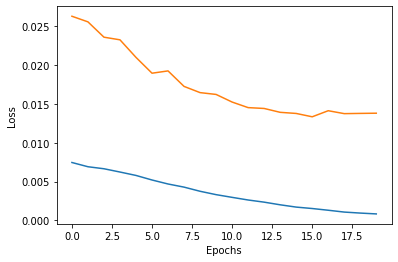

In [59]:
plt.plot(train_loss_plot, label="train loss")
plt.plot(valid_loss_plot, label="validation loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

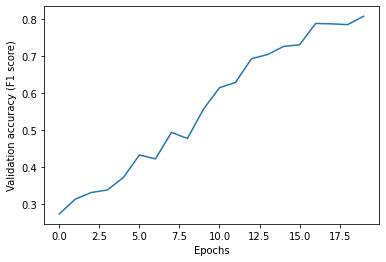

In [60]:
plt.plot(valid_acc_plot)
plt.ylabel("Validation accuracy (F1 score)")
plt.xlabel("Epochs")
plt.show()

In [61]:
pred = []
for test_case in range(len(test_df)):
    example = test_df['text'][test_case]
    encodings = tokenizer.encode_plus(
        example,
        None,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        return_token_type_ids=True,
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    model.eval()
    
    with torch.no_grad():
        input_ids = encodings['input_ids'].to(device, dtype=torch.long)
        attention_mask = encodings['attention_mask'].to(device, dtype=torch.long)
        token_type_ids = encodings['token_type_ids'].to(device, dtype=torch.long)
        output = model(input_ids, attention_mask, token_type_ids)
        final_output = torch.sigmoid(output).cpu().detach().numpy().tolist()
        pred.append(final_output[0])

In [63]:
pred = np.array(np.array(pred) > 0.5).astype(np.float)
answer = np.array(test_df[target_list]).astype(np.float)

In [64]:
test_f1 = 0
for i, tag in enumerate(target_list):
    tag_f1_score = f1_score(answer[:, i], pred[:, i])
    test_f1 += tag_f1_score
    print(f"F1 score of {tag} tag: {tag_f1_score}")
test_f1 /= len(target_list)
print(f"Test accuracy: {test_f1}")

F1 score of binary search tag: 0.11475409836065574
F1 score of bitmasks tag: 0.0
F1 score of brute force tag: 0.21960784313725487
F1 score of combinatorics tag: 0.15384615384615383
F1 score of constructive algorithms tag: 0.14184397163120568
F1 score of data structures tag: 0.28205128205128205
F1 score of dfs and similar tag: 0.2711864406779661
F1 score of dp tag: 0.33529411764705874
F1 score of dsu tag: 0.08
F1 score of geometry tag: 0.5757575757575758
F1 score of graphs tag: 0.5454545454545455
F1 score of greedy tag: 0.30687830687830686
F1 score of implementation tag: 0.5316901408450704
F1 score of math tag: 0.35978835978835977
F1 score of number theory tag: 0.36923076923076925
F1 score of sortings tag: 0.23529411764705882
F1 score of strings tag: 0.5505617977528089
F1 score of trees tag: 0.4000000000000001
F1 score of two pointers tag: 0.125
Test accuracy: 0.29464418530031966


In [65]:
example = """
Given a list of D digits and an integer K, we consider all different ways to permute these digits
into a D-digit decimal number. The target of this problem is to find a permutation X, such
that when X is divided by K, the remainder (between 0 and K − 1) is the largest among
all other permutations. If there are more than one possible permutation, output the largest
permutation.
For instance, suppose that we have D = 3 digits, and they are respectively 1, 2, 3.
1. If K = 1, then we see that every permutation will give a remainder 0 when divided by K,
and 321 is thus the desired answer, as it is the largest permutation among all.
2. If K = 10, then both 123 and 213 will give a remainder 3 when divided by K, and this is
the largest possible remainder in this case. Consequently, the desired output is 213 since
it is a larger permutation.
3. If K = 100, then the largest remainder we can get is 32, when the permutation is 132.
Input Format
The first line of the input contains a positive integer D followed by a positive integer K. Then,
the next line contains D digits, each digit d has value 1 ≤ d ≤ 9 and is separated from the next
one by a space.
Output Format
Output the largest permutation that gives the largest remainder in a single line.
Technical Specification
∙ 1 ≤ D ≤ 16
∙ 1 ≤ K ≤ 200
∙ 1 ≤ d ≤ 9
"""
encodings = tokenizer.encode_plus(
    example,
    None,
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    return_token_type_ids=True,
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)
model.eval()
with torch.no_grad():
    input_ids = encodings['input_ids'].to(device, dtype=torch.long)
    attention_mask = encodings['attention_mask'].to(device, dtype=torch.long)
    token_type_ids = encodings['token_type_ids'].to(device, dtype=torch.long)
    output = model(input_ids, attention_mask, token_type_ids)
    final_output = torch.sigmoid(output).cpu().detach().numpy().tolist()
    print(f"Tags for the problem: ")
    for i, prob in enumerate(final_output[0]):
        if prob >= 0.5:
            print(target_list[i], end=' ')
    print()

Tags for the problem: 
constructive algorithms dp greedy math number theory 


In [66]:
best_model = BERTClass()
best_model.to(device)
best_optimize = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)
best_model, best_optimize, best_epoch = load_ckp("best_model.pt", best_model, best_optimize)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [67]:
pred = []
for test_case in range(len(test_df)):
    example = test_df['text'][test_case]
    encodings = tokenizer.encode_plus(
        example,
        None,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        return_token_type_ids=True,
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    best_model.eval()
    
    with torch.no_grad():
        input_ids = encodings['input_ids'].to(device, dtype=torch.long)
        attention_mask = encodings['attention_mask'].to(device, dtype=torch.long)
        token_type_ids = encodings['token_type_ids'].to(device, dtype=torch.long)
        output = best_model(input_ids, attention_mask, token_type_ids)
        final_output = torch.sigmoid(output).cpu().detach().numpy().tolist()
        pred.append(final_output[0])
        
pred = np.array(np.array(pred) > 0.5).astype(np.float)
answer = np.array(test_df[target_list]).astype(np.float)

test_f1 = 0
for i, tag in enumerate(target_list):
    tag_f1_score = f1_score(answer[:, i], pred[:, i])
    test_f1 += tag_f1_score
    print(f"F1 score of {tag} tag: {tag_f1_score}")
test_f1 /= len(target_list)
print(f"Test accuracy: {test_f1}")

F1 score of binary search tag: 0.11864406779661017
F1 score of bitmasks tag: 0.02898550724637681
F1 score of brute force tag: 0.29949238578680204
F1 score of combinatorics tag: 0.2
F1 score of constructive algorithms tag: 0.1803921568627451
F1 score of data structures tag: 0.2601626016260163
F1 score of dfs and similar tag: 0.32142857142857145
F1 score of dp tag: 0.35260115606936415
F1 score of dsu tag: 0.13114754098360656
F1 score of geometry tag: 0.512396694214876
F1 score of graphs tag: 0.5048543689320388
F1 score of greedy tag: 0.3005464480874317
F1 score of implementation tag: 0.5611940298507463
F1 score of math tag: 0.3665768194070081
F1 score of number theory tag: 0.39393939393939387
F1 score of sortings tag: 0.23863636363636362
F1 score of strings tag: 0.5477707006369428
F1 score of trees tag: 0.4776119402985075
F1 score of two pointers tag: 0.07692307692307691
Test accuracy: 0.3091212538803409


In [68]:
example = """
Given a list of D digits and an integer K, we consider all different ways to permute these digits
into a D-digit decimal number. The target of this problem is to find a permutation X, such
that when X is divided by K, the remainder (between 0 and K − 1) is the largest among
all other permutations. If there are more than one possible permutation, output the largest
permutation.
For instance, suppose that we have D = 3 digits, and they are respectively 1, 2, 3.
1. If K = 1, then we see that every permutation will give a remainder 0 when divided by K,
and 321 is thus the desired answer, as it is the largest permutation among all.
2. If K = 10, then both 123 and 213 will give a remainder 3 when divided by K, and this is
the largest possible remainder in this case. Consequently, the desired output is 213 since
it is a larger permutation.
3. If K = 100, then the largest remainder we can get is 32, when the permutation is 132.
Input Format
The first line of the input contains a positive integer D followed by a positive integer K. Then,
the next line contains D digits, each digit d has value 1 ≤ d ≤ 9 and is separated from the next
one by a space.
Output Format
Output the largest permutation that gives the largest remainder in a single line.
Technical Specification
∙ 1 ≤ D ≤ 16
∙ 1 ≤ K ≤ 200
∙ 1 ≤ d ≤ 9
"""
encodings = tokenizer.encode_plus(
    example,
    None,
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    return_token_type_ids=True,
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)
best_model.eval()
with torch.no_grad():
    input_ids = encodings['input_ids'].to(device, dtype=torch.long)
    attention_mask = encodings['attention_mask'].to(device, dtype=torch.long)
    token_type_ids = encodings['token_type_ids'].to(device, dtype=torch.long)
    output = best_model(input_ids, attention_mask, token_type_ids)
    final_output = torch.sigmoid(output).cpu().detach().numpy().tolist()
    print(f"Tags for the problem: ")
    for i, prob in enumerate(final_output[0]):
        if prob >= 0.3:
            print(target_list[i], end=' ')
    print()

Tags for the problem: 
brute force constructive algorithms dp greedy math number theory 


In [69]:
example = """
compute the sum of two number
"""
encodings = tokenizer.encode_plus(
    example,
    None,
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    return_token_type_ids=True,
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)
best_model.eval()
with torch.no_grad():
    input_ids = encodings['input_ids'].to(device, dtype=torch.long)
    attention_mask = encodings['attention_mask'].to(device, dtype=torch.long)
    token_type_ids = encodings['token_type_ids'].to(device, dtype=torch.long)
    output = best_model(input_ids, attention_mask, token_type_ids)
    final_output = torch.sigmoid(output).cpu().detach().numpy().tolist()
    print(f"Tags for the problem: ")
    for i, prob in enumerate(final_output[0]):
        if prob >= 0.5:
            print(target_list[i], end=' ')
    print()

Tags for the problem: 
binary search constructive algorithms data structures dp dsu graphs greedy math sortings 
